# Collecting data from an environment

In [1]:
from cc.env.collect import (
    collect,
    collect_exhaust_source,
    sample_feedforward_and_collect,
    sample_feedforward_collect_and_make_source,
    concat_samples
)
from cc import save, load 
from cc.env import make_env
from cc.env.wrappers import AddRefSignalRewardFnWrapper
import matplotlib.pyplot as plt 
from cc.utils.utils import timestep_array_from_env

In [2]:
time_limit=5.0 # s
control_timestep=0.01 # s 

env = make_env(
    "two_segments_v1", 
    random=1, # the initial condition might be randomized; fixes the seed 
    control_timestep=control_timestep, # the control rate, here 100 Hz 
    time_limit=time_limit, # the upper time limit; after 5 seconds the environment is done
    delay=0 # whether or not the action is delayed before the environment sees it 
    )

In [3]:
ts = timestep_array_from_env(env)

##### Therefore the length of an episode trajectory will be

In [4]:
N = len(ts)+1 # +1 for the initial state (no action performed yet)
N

501

#### And we apply inputs at those timesteps

In [5]:
ts[:20]

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19])

#### The input to the system and observation from the system is of the form

In [6]:
env.action_spec()

BoundedArray(shape=(1,), dtype=dtype('float32'), name=None, minimum=[-1.e+10], maximum=[1.e+10])

In [7]:
env.observation_spec()

OrderedDict([('xpos_of_segment_end',
              Array(shape=(1,), dtype=dtype('float32'), name='xpos_of_segment_end'))])

In [8]:
env.step([0.1])

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('xpos_of_segment_end', array([2.5717583e-16], dtype=float32))]))

In [9]:
env.reset()

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('xpos_of_segment_end', array([2.5717583e-16], dtype=float32))]))

##### Let's collect some data from the environment

In [10]:
train_sample = sample_feedforward_and_collect(
    env, 
    seeds_gp=[0,1,2], # this uses a gaussian process to draw some fixed action/input trajectories 
                        # that we then can apply to the system and record the output
    seeds_cos=[2,4] # this uses a cosine-wave with a frequency of 2 and 4; really this shouldn't 
                        # be called seed 
    )

In [11]:
type(train_sample)

cc.env.buffer.replay_element_sample.ReplaySample

In [12]:
train_sample.bs

5

In [13]:
train_sample.action.shape

(5, 500, 1)

In [14]:
train_sample.obs["xpos_of_segment_end"].shape

(5, 501, 1)

In [15]:
%matplotlib inline

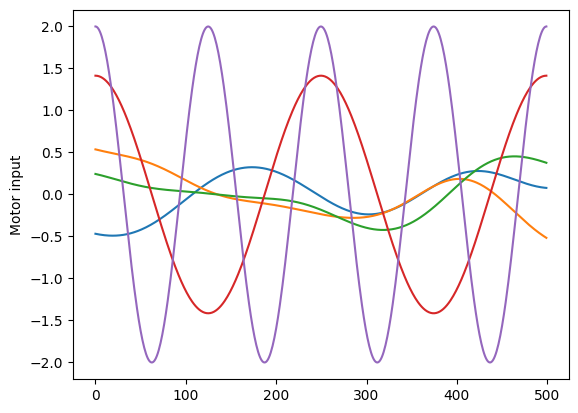

In [16]:
for idx in range(train_sample.bs):
    plt.plot(train_sample.action[idx])
plt.ylabel("Motor input")
plt.show()

Text(0, 0.5, 'X-Position')

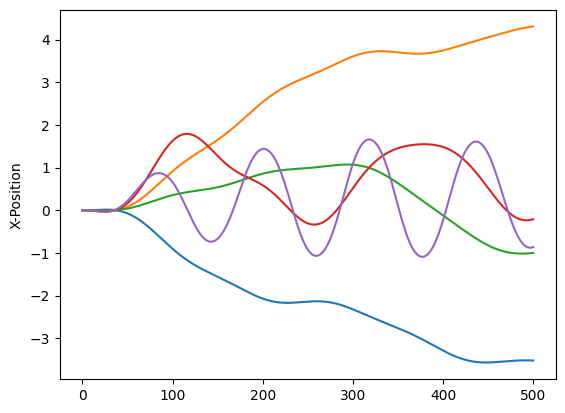

In [17]:
for idx in range(train_sample.bs):
    plt.plot(train_sample.obs["xpos_of_segment_end"][idx])
plt.ylabel("X-Position")

In [18]:
train_sample.rew[0,:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

Notice how there is no reward, how could there be? 

We have to add 
- first, create some reference output that we want to track
- second, add the reference to the environment and specify a reward-function

Let's now create an arbitrary smooth input-trajectory, record the observation of that input as reference and store it 

In [19]:
reference_source, replay_sample, _ = sample_feedforward_collect_and_make_source(env, seeds = [0,17])
# we don't need the replay_sample anymore
del replay_sample

In [20]:
env_w_rew = AddRefSignalRewardFnWrapper(env, reference_source)

Now, the observation is the reference and the actual observation

In [21]:
env_w_rew.observation_spec()

OrderedDict([('ref',
              OrderedDict([('xpos_of_segment_end',
                            Array(shape=(1,), dtype=dtype('float32'), name='xpos_of_segment_end'))])),
             ('obs',
              OrderedDict([('xpos_of_segment_end',
                            Array(shape=(1,), dtype=dtype('float32'), name='xpos_of_segment_end'))]))])

And the environment now has some reward

In [22]:
env_w_rew.step([0.1]).reward

Array(-1.7880125e-10, dtype=float32)

In [23]:
env_w_rew.step([0.1]).reward

Array(-9.162138e-10, dtype=float32)

Remember, how our source contains *2* trajectories. So, which one are we currently "seeing" in this environment in the observation

In [24]:
reference_source._i_actor

0

In [25]:
env_w_rew.reset()
env_w_rew.step([0.1]).observation["ref"]

OrderedDict([('xpos_of_segment_end', Array([-1.0890691e-05], dtype=float32))])

In [26]:
# let's change the reference to the second one 
reference_source.change_reference_of_actor(1)
reference_source._i_actor

1

In [27]:
# now it is different
env_w_rew.reset()
env_w_rew.step([0.1]).observation["ref"]

OrderedDict([('xpos_of_segment_end', Array([-4.5886345e-06], dtype=float32))])

### Now we have all the components to 
- get Training/Testing-data for the training of a *model* using `sample_feedforward_and_collect`
- get suitable Reference Trajectories using `sample_feedforward_collect_and_make_source` and add this reference to the environment

##### Finally, you can also save/load `source` and `train_sample` using the functions `save` and `load`

In [28]:
save(train_sample, "train_sample.pkl")
load("train_sample.pkl")

ReplaySample(obs=OrderedDict([('xpos_of_segment_end', array([[[ 2.57175826e-16],
        [-1.08906906e-05],
        [-2.46612472e-05],
        ...,
        [-3.51896811e+00],
        [-3.51956797e+00],
        [-3.52024055e+00]],

       [[ 2.57175826e-16],
        [ 1.22656975e-05],
        [ 2.76726369e-05],
        ...,
        [ 4.30095720e+00],
        [ 4.30360889e+00],
        [ 4.30604124e+00]],

       [[ 2.57175826e-16],
        [ 5.96579366e-06],
        [ 1.34270213e-05],
        ...,
        [-1.00349724e+00],
        [-1.00140285e+00],
        [-9.99171495e-01]],

       [[ 2.57175826e-16],
        [ 2.37798831e-05],
        [ 5.37460292e-05],
        ...,
        [-2.21253112e-01],
        [-2.15807766e-01],
        [-2.09519133e-01]],

       [[ 2.57175826e-16],
        [ 2.75593084e-05],
        [ 6.22796142e-05],
        ...,
        [-8.75280976e-01],
        [-8.69375408e-01],
        [-8.60554099e-01]]], dtype=float32))]), action=array([[[-0.46774825],
        [-0.